In [1]:
import sys
sys.path.append("../Algorithms/")

In [6]:
import numpy as np 
from numpy import linalg as la
from numpy.random import uniform
from matplotlib import pyplot as plt 
from sklearn.decomposition import PCA 
from sklearn import datasets
from time import time

from random_svd import randomized_svd

Motivation:  
The solution to a least squares problem $Ax = b$ can be found using the following steps:
1. Approximate $A = U \Sigma V^*$.
2. Solve the diagonal system $\Sigma V^* x = U^* b$ for $y = V^*x$.
3. Compute $x = V y$.

This method is ideal because it is almost always stable, however the computation of the SVD makes this very costly. Our goal here is to test how accurately we can solve least squares problems (compared to other, less costly methods such as QR or Cholesky decomposition) by using a randomized SVD algorithm to make this method more computationally efficient.

In [3]:
def randomized_svd_solve(A, b, k, r = 2, q = 0, range_method = 'qr', proportion=None):
    ''' Use the Randomized SVD algorithm to compute the solution to the least-squares 
        problem defined by Ax = b.

        Parameters:
            A (ndarray) : the mxn matrix defining the left hand side 
            b (ndarray) : the nx1 vector defining the right hand side
            k, r, q, range_method : see docs for randomized_svd method
            
        Returns:
            x (ndarray) : the mx1 vector that is the solution to the least squares problem
            rel_error (float) : the relative error in the residual, combuted as 
                                  ||b - Ax|| / ||b||
            compute_time (float) : computation time for solving the system
    '''
    start = time()
    # print("random!")

    # compute the SVD of A using randomized algorithm 
    U, S, Vh = randomized_svd(A=A, k=k, r=r, q=q, range_method=range_method, proportion=proportion)

    # print("U")
    # print((U.T @ b).shape)
    # print("S")
    # print(S.shape)
    # solve the diagonal system for y = V*x
    y = (U.T @ b) / S 

    # compute x = Vy 
    x = Vh.T @ y 

    end = time()

    # compute the relative error in the residual 
    rel_error = la.norm(b - A @ x, ord=2) / la.norm(b, ord=2)

    return x, rel_error, end - start


def numpy_svd_solve(A, b):
    ''' UseNumPy's built-in truncated SVD algorithm to compute the 
        solution to the least-squares problem defined by Ax = b.

        Parameters:
            A (ndarray) : the mxn matrix defining the left hand side 
            b (ndarray) : the nx1 vector defining the right hand side

        Returns:
            x (ndarray) : the mx1 vector that is the solution to the least squares problem
            rel_error (ndarray) : the relative error in the residual, combuted as 
                                  ||b - Ax|| / ||b||
            compute_time (float) : computation time for solving the system
    '''
    start = time() 

    # compute the SVD of A using randomized algorithm 
    U, S, Vh = la.svd(A, full_matrices=False)

    # solve the diagonal system for y = V*x
    y = (1 / S) * U.T @ b 

    # compute x = Vy 
    x = Vh.T @ y 

    end = time()

    # compute the relative error in the residual 
    rel_error = la.norm(b - A @ x, ord=2) / la.norm(b, ord=2)

    return x, rel_error, end - start


def numpy_qr_solve(A, b):
    ''' Use the NumPy's built-in QR decomposition algorithm to compute the 
        solution to the least-squares problem defined by Ax = b.

        Parameters:
            A (ndarray) : the mxn matrix defining the left hand side 
            b (ndarray) : the nx1 vector defining the right hand side

        Returns:
            x (ndarray) : the mx1 vector that is the solution to the least squares problem
            rel_error (ndarray) : the relative error in the residual, combuted as 
                                  ||b - Ax|| / ||b||
            compute_time (float) : computation time for solving the system
    '''
    start = time() 

    # compute the QR decomposition of A 
    Q, R = la.qr(A, mode="reduced")

    # solve the upper triangular system Rx = Q*b
    x = la.solve(R, Q.T @ b)

    end = time() 

    # compute the relative error in the residual 
    rel_error = la.norm(b - A @ x, ord=2) / la.norm(b, ord=2)

    return x, rel_error, end - start 


def numpy_lu_solve(A, b):
    ''' Use the NumPy's built-in linalg.solve() method (which uses LU decomposition with partial pivoting) 
        to compute the solution to the least-squares problem defined by Ax = b.

        Parameters:
            A (ndarray) : the mxn matrix defining the left hand side 
            b (ndarray) : the nx1 vector defining the right hand side

        Returns:
            x (ndarray) : the mx1 vector that is the solution to the least squares problem
            rel_error (ndarray) : the relative error in the residual, combuted as 
                                  ||b - Ax|| / ||b||
            compute_time (float) : computation time for solving the system
    '''
    start = time() 

    # solve the system 
    x = la.solve(A, b)

    end = time()

    # compute the relative error in the residual 
    rel_error = la.norm(b - A @ x, ord=2) / la.norm(b, ord=2)

    return x, rel_error, end - start

Plot runtimes and errors for matrices of increasing size.

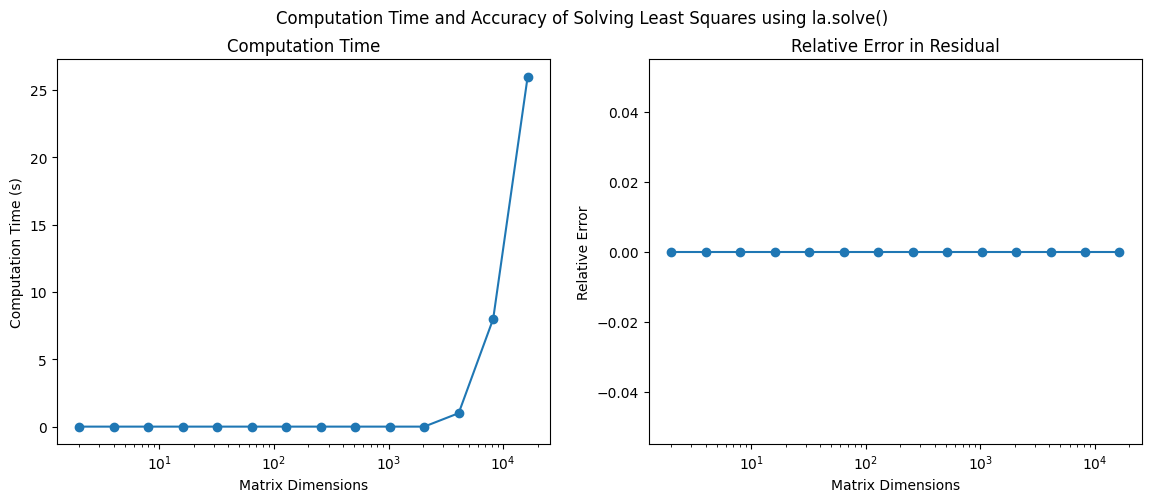

In [4]:
# using la.solve()
m_vals = 2 ** np.arange(1, 15)
n_vals = m_vals.copy()

errors = np.zeros_like(m_vals)
runtimes = np.zeros_like(m_vals)

for i, (m, n) in enumerate(zip(m_vals, n_vals)):

    # randomly sample a linear system
    A = uniform(size=(m, n))
    b = uniform(size=m)

    # solve using la.solve()
    x, rel_error, compute_time = numpy_lu_solve(A, b)
    errors[i] = rel_error 
    runtimes[i] = compute_time

    # plot relative errors and runtimes against matrix dimension
plt.figure(figsize=(14, 5))

plt.subplot(121)
plt.plot(m_vals, runtimes, marker='o')
plt.title("Computation Time")
plt.xlabel("Matrix Dimensions")
plt.ylabel("Computation Time (s)")
plt.xscale("log")

plt.subplot(122)
plt.plot(m_vals, errors, marker='o')
plt.title("Relative Error in Residual")
plt.xlabel("Matrix Dimensions")
plt.ylabel("Relative Error")
plt.xscale("log")

plt.suptitle("Computation Time and Accuracy of Solving Least Squares using la.solve()")
plt.show()

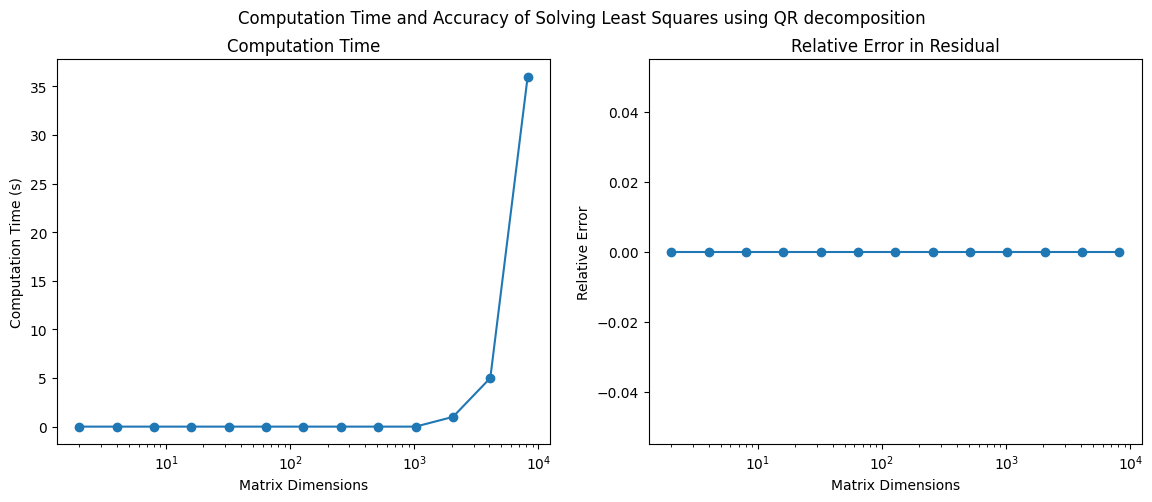

In [5]:
# using numpy qr
m_vals = 2 ** np.arange(1, 14)
n_vals = m_vals.copy()

errors = np.zeros_like(m_vals)
runtimes = np.zeros_like(m_vals)

for i, (m, n) in enumerate(zip(m_vals, n_vals)):

    # randomly sample a linear system
    A = uniform(size=(m, n))
    b = uniform(size=m)

    # solve using la.solve()
    x, rel_error, compute_time = numpy_qr_solve(A, b)
    errors[i] = rel_error 
    runtimes[i] = compute_time

    # plot relative errors and runtimes against matrix dimension
plt.figure(figsize=(14, 5))

plt.subplot(121)
plt.plot(m_vals, runtimes, marker='o')
plt.title("Computation Time")
plt.xlabel("Matrix Dimensions")
plt.ylabel("Computation Time (s)")
plt.xscale("log")

plt.subplot(122)
plt.plot(m_vals, errors, marker='o')
plt.title("Relative Error in Residual")
plt.xlabel("Matrix Dimensions")
plt.ylabel("Relative Error")
plt.xscale("log")

plt.suptitle("Computation Time and Accuracy of Solving Least Squares using QR decomposition")
plt.show()

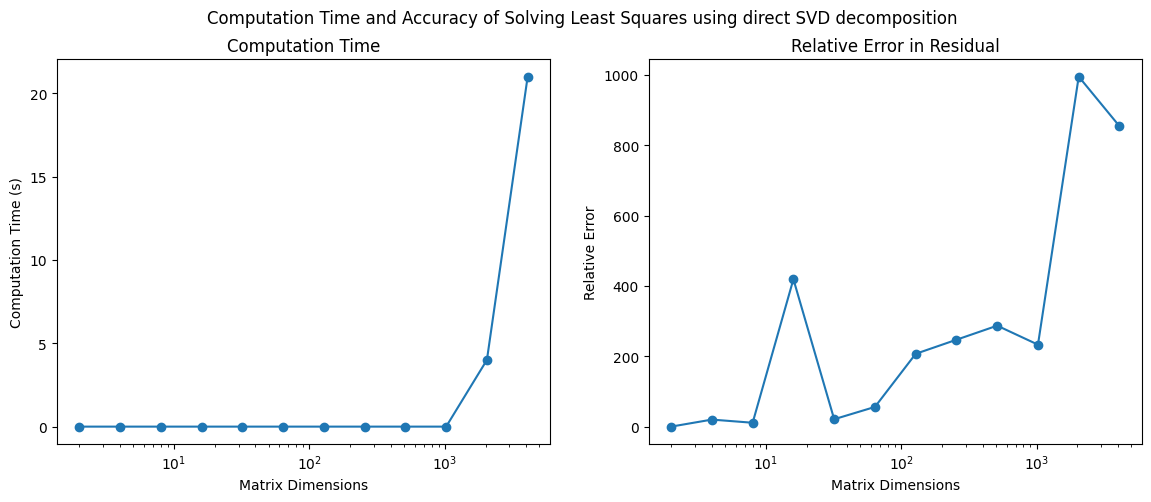

In [13]:
# using numpy svd
m_vals = 2 ** np.arange(1, 13)
n_vals = m_vals.copy()

errors = np.zeros_like(m_vals)
runtimes = np.zeros_like(m_vals)

for i, (m, n) in enumerate(zip(m_vals, n_vals)):

    # randomly sample a linear system
    A = uniform(size=(m, n))
    b = uniform(size=m)

    # solve using la.solve()
    x, rel_error, compute_time = numpy_svd_solve(A, b)
    errors[i] = rel_error 
    runtimes[i] = compute_time

    # plot relative errors and runtimes against matrix dimension
plt.figure(figsize=(14, 5))

plt.subplot(121)
plt.plot(m_vals, runtimes, marker='o')
plt.title("Computation Time")
plt.xlabel("Matrix Dimensions")
plt.ylabel("Computation Time (s)")
plt.xscale("log")

plt.subplot(122)
plt.plot(m_vals, errors, marker='o')
plt.title("Relative Error in Residual")
plt.xlabel("Matrix Dimensions")
plt.ylabel("Relative Error")
plt.xscale("log")

plt.suptitle("Computation Time and Accuracy of Solving Least Squares using direct SVD decomposition")
plt.show()

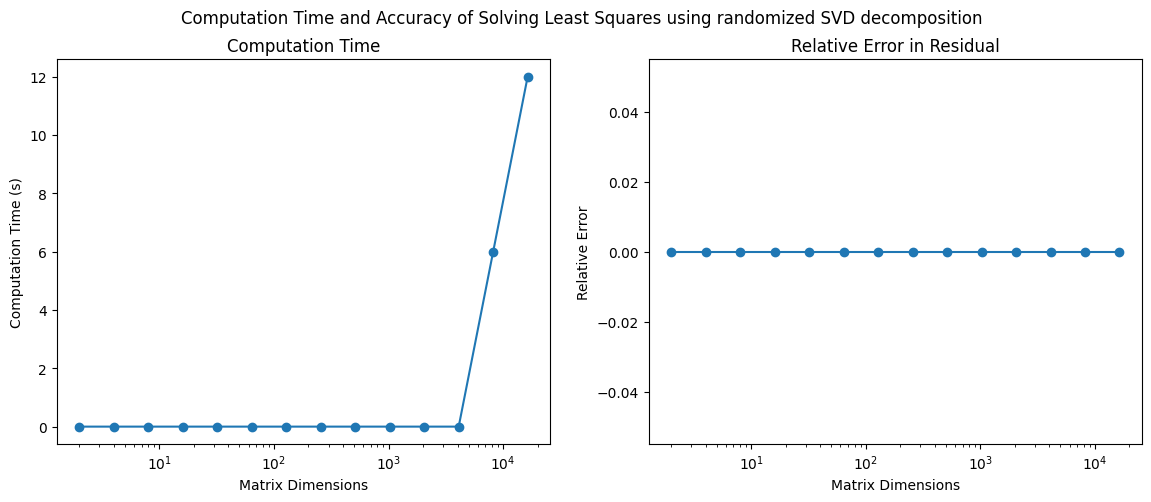

In [8]:
# using randomized svd
m_vals = 2 ** np.arange(1, 15)
n_vals = m_vals.copy()

errors = np.zeros_like(m_vals)
runtimes = np.zeros_like(m_vals)

for i, (m, n) in enumerate(zip(m_vals, n_vals)):

    # randomly sample a linear system
    A = uniform(size=(m, n))
    b = uniform(size=m)

    if m <= 100:
        rank = m // 2
    else:
        rank = 10

    if m <= 50:
        prop = None 
    elif m <= 1000:
        prop = 0.5
    # elif m <= 5000:
    #     prop = 0.1
    else:
        prop = 0.05
    # solve using la.solve()
    x, rel_error, compute_time = randomized_svd_solve(A, b, k=np.max([2, rank]), r=0, q=0, range_method="qr", proportion=prop)
    errors[i] = rel_error 
    runtimes[i] = compute_time

    # plot relative errors and runtimes against matrix dimension
plt.figure(figsize=(14, 5))

plt.subplot(121)
plt.plot(m_vals, runtimes, marker='o')
plt.title("Computation Time") 
plt.xlabel("Matrix Dimensions")
plt.ylabel("Computation Time (s)")
plt.xscale("log")

plt.subplot(122)
plt.plot(m_vals, errors, marker='o')
plt.title("Relative Error in Residual")
plt.xlabel("Matrix Dimensions")
plt.ylabel("Relative Error")
plt.xscale("log")

plt.suptitle("Computation Time and Accuracy of Solving Least Squares using randomized SVD decomposition")
plt.show()